# QLearning for UNO

### Import necessary libraries

In [1]:
import os
import numpy as np
import torch
import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
)

import os
import torch
import rlcard
from rlcard.agents import UnoHumanAgent as HumanAgent  # Import the playable human agent for UNO
from rlcard.utils import print_card

### Train Agent

#### Standard Situation: 2 Players

In [6]:
def train(env_name, seed, num_episodes, num_eval_games, evaluate_every, log_dir, cuda):
    # Check whether GPU is available and set the device accordingly
    device = get_device()
    algorithm='dqn'

    # Seed numpy, torch, and Python's built-in random module for reproducibility
    set_seed(seed)

    # Create the game environment with a specified seed to ensure consistency across runs
    env = rlcard.make(
        env_name,
        config={
            'seed': seed,
        }
    )

    # Initialize the agent based on the chosen algorithm
    if algorithm == 'dqn':
        from rlcard.agents import DQNAgent
        agent = DQNAgent(
            num_actions=env.num_actions,  # Number of possible actions in the game
            state_shape=env.state_shape[0],  # Shape of the state space
            mlp_layers=[128, 128],  # Define the architecture of the neural network  
            device=device,  # Specify the device (CPU or GPU) for training
            learning_rate=0.0001,  # Adjust learning rate
            batch_size=64,  # Adjust batch size
        )
        
    # Create a list to hold the agents, starting with the main agent
    agents = [agent]
    # Add random agents for the other players in the game -> so if DQN/NFSP is better than other players, it's better than playing randomly
    for _ in range(1, env.num_players):
        agents.append(RandomAgent(num_actions=env.num_actions))
    # Set the agents for the environment
    env.set_agents(agents)

    # Start the training process and create a logger to record performance data
    with Logger(log_dir) as logger:
        for episode in range(num_episodes):
            # Run one episode of the game environment to generate data
            trajectories, payoffs = env.run(is_training=True)

            # Reorganize the data to be in the form: state, action, reward, next_state, done
            trajectories = reorganize(trajectories, payoffs)

            # Feed transitions into the agent's memory and train the agent
            # Assume that the main agent is always in the first position
            for ts in trajectories[0]:
                agent.feed(ts)

            # Evaluate the agent's performance at regular intervals
            if episode % evaluate_every == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        env,
                        num_eval_games,  # Number of games to play for evaluation
                    )[0]
                )

        # Get the paths for the CSV log and the performance plot
        csv_path, fig_path = logger.csv_path, logger.fig_path

    # Plot the learning curve using the logged data
    plot_curve(csv_path, fig_path, algorithm)

    # Save the trained model to a file
    save_path = os.path.join(log_dir, 'model.pth')
    torch.save(agent, save_path)
    print('Model saved in', save_path)

### Set Parameters for UNO Training

In [7]:
# Set parameters directly for training
env_name = 'uno'
seed = 42
num_episodes = 5000
num_eval_games = 200 # play 200 games and calculate average win rate (1 for win 0 for loss) as reward
evaluate_every = 100
log_dir = 'experiments/uno_dqn_result/'
cuda = ''  # Empty string means using the first available GPU

# Set CUDA_VISIBLE_DEVICES environment variable for GPU selection
os.environ["CUDA_VISIBLE_DEVICES"] = cuda

### Train Agent

In UNO, the agent will get a payoff at the end of the game: 1 if the agent wins, -1 if the agent loses. The performance is measured by the average payoff the player obtains by playing 'num_eval_games' episodes. 

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  0.11
----------------------------------------
INFO - Step 100, rl-loss: 0.5500485301017761
INFO - Copied model parameters to target network.
INFO - Step 1100, rl-loss: 0.062185987830162056
INFO - Copied model parameters to target network.
INFO - Step 2100, rl-loss: 0.078360415995121515
INFO - Copied model parameters to target network.
INFO - Step 2325, rl-loss: 0.12418569624423981
----------------------------------------
  episode      |  100
  reward       |  0.06
----------------------------------------
INFO - Step 3100, rl-loss: 0.053819201886653985
INFO - Copied model parameters to target network.
INFO - Step 4100, rl-loss: 0.047581516206264496
INFO - Copied model parameters to target network.
INFO - Step 4756, rl-loss: 0.070273756980896704
----------------------------------------
  episode      |  200
  reward       |  -0.04
----------------------------------------
INFO - Step 51

INFO - Step 47100, rl-loss: 0.23124466836452484
INFO - Copied model parameters to target network.
INFO - Step 48100, rl-loss: 0.154355585575103766
INFO - Copied model parameters to target network.
INFO - Step 48453, rl-loss: 0.18606324493885047
----------------------------------------
  episode      |  2100
  reward       |  0.01
----------------------------------------
INFO - Step 49100, rl-loss: 0.16086062788963318
INFO - Copied model parameters to target network.
INFO - Step 50100, rl-loss: 0.19167912006378174
INFO - Copied model parameters to target network.
INFO - Step 50730, rl-loss: 0.15643130242824554
----------------------------------------
  episode      |  2200
  reward       |  0.01
----------------------------------------
INFO - Step 51100, rl-loss: 0.15505215525627136
INFO - Copied model parameters to target network.
INFO - Step 52100, rl-loss: 0.26164895296096804
INFO - Copied model parameters to target network.
INFO - Step 52902, rl-loss: 0.26631850004196167
-----------

INFO - Step 95100, rl-loss: 1.8026729822158813
INFO - Copied model parameters to target network.
INFO - Step 96100, rl-loss: 3.3477439880371094
INFO - Copied model parameters to target network.
INFO - Step 96671, rl-loss: 1.6364276409149177
----------------------------------------
  episode      |  4100
  reward       |  0.13
----------------------------------------
INFO - Step 97100, rl-loss: 2.5313124656677246
INFO - Copied model parameters to target network.
INFO - Step 98100, rl-loss: 2.5838410854339628
INFO - Copied model parameters to target network.
INFO - Step 98989, rl-loss: 1.4317773580551147
----------------------------------------
  episode      |  4200
  reward       |  0.05
----------------------------------------
INFO - Step 99100, rl-loss: 1.4227279424667358
INFO - Copied model parameters to target network.
INFO - Step 100100, rl-loss: 1.6970546245574951
INFO - Copied model parameters to target network.
INFO - Step 101100, rl-loss: 1.2984174489974976
INFO - Copied model

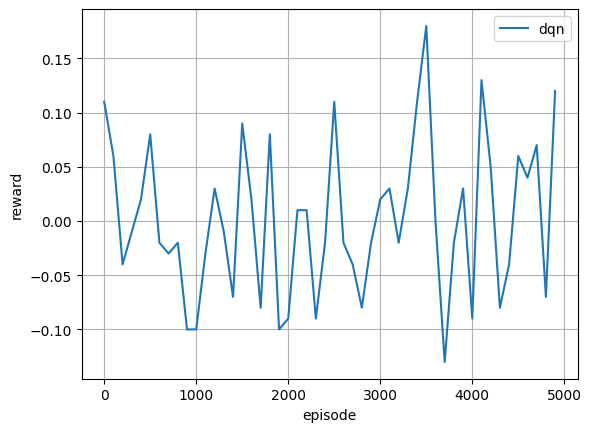

In [8]:
# Train the agent with the specified parameters
train(env_name, seed, num_episodes, num_eval_games, evaluate_every, log_dir, cuda)

### Play Against Trained  UNO Agent

In [ ]:
# Define the environment and agents
env_name = 'uno'  
model_path = 'experiments/uno_dqn_result/model.pth'  # Path to our trained model

# Load the environment
env = rlcard.make(env_name)

# Initialize the human agent that can be played as
human_agent = HumanAgent(env.num_actions)

# Load the trained agent
trained_agent = torch.load(model_path, map_location=torch.device('cpu'))

# Set the agents in the environment
env.set_agents([
    human_agent,
    trained_agent,
])

print(f">> {env_name.capitalize()} trained model")

while True:
    print(">> Start a new game")

    # Run an episode
    trajectories, payoffs = env.run(is_training=False)

    # If the human does not take the final action, we need to print other players' actions
    final_state = trajectories[0][-1]
    action_record = final_state['action_record']
    state = final_state['raw_obs']
    _action_list = []
    for i in range(1, len(action_record) + 1):
        if action_record[-i][0] == state['current_player']:
            break
        _action_list.insert(0, action_record[-i])
    for pair in _action_list:
        print('>> Player', pair[0], 'chooses', pair[1])

    # Display the cards of the trained agent
    print('===============     Trained Agent    ===============')
    print_card(env.get_perfect_information()['hand_cards'][1])
    
    #lem        state['hand_cards'] = [self.game.players[i].hand.get_index() for i in range(self.num_players)]
 #   state['hand_cards'] = [cards2list(player.hand) for player in self.game.players]

    # Display the game result
    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('You win! Congrats :3')
    elif payoffs[0] == 0:
        print('It is a tie. Your remaining cards: {}'.format(len(state['hand'])))
    else:
        print('You lose. Your remaining cards: {}'.format(len(state['hand'])))
    print('')

    input("Press any key to continue...")

